[Table of Contents](00.00-Learning-ML.ipynb#Table-of-Contents) &bull; [&larr; *Chapter 2.01 - Dummy Classifiers*](02.01-Dummy-Classifiers.ipynb) &bull; [*Chapter 2.03 - k-Nearest Neighbours* &rarr;](02.03-k-Nearest-Neighbours.ipynb)

---

# Chapter 2.02 - Naive Bayes

In statistics, *Bayes theorem* describes the probability of an occurence based on input conditions. The theorem states: the probability of A given B is equal to the probability of B given A multiplied by the probability of A and divided by the probability of B, or notationally:

    P(A|B) = P(B|A) * P(A) / P(B)

`P()` means *the probability of* and `|` means *given* or "where".

In other words `P(A|B)` means "the probability of A occuring when B occurs".

A naive Bayes classifier applies this theorem naively, assuming that features (inputs into) in the model are indepedent of (unrelated to) each other.

In the previous chapter, we looked at using class probabilities to build a dummy classifier, and considered an example that 95% of loans do not default. This probability is known as a *prior* probability - it is known without knowing anything about the class inputs.


## Proof of Bayes theorem

We can prove Bayes theorem by starting with the probability of two events, A and B, occuring together.

    P(A and B) = P(A) * P(B|A)
    also
    P(A and B) = P(B) * P(A|B)

Equating the right sides of each equation:

    P(B) * P(A|B) = P(A) * P(B|A)

Divide both sides by `P(B)`, gives us Bayes theorem:

    P(A|B) = P(A) * P(B|A) / P(B)

## Binary inputs

Let's expand our dummy classifier example with some input:

| Employment | Default | Count |
|---|---|---|
| FT | N | 59 |
| FT | Y | 1 |
| PT | N | 36 |
| PT | Y | 4 |

Probability of default given full-time employment:

    P(Default=Y|Emp=FT) = P(Default=Y) * P(Emp=FT|Default=Y) / P(Emp=FT)

    = 0.05 * 0.2 / 0.6
    = 0.0167...

Probability of default given part-time employment:

    P(Default=Y|Emp=PT) = P(Default=Y) * P(Emp=PT|Default=Y) / P(Emp=PT)

    = 0.05 * 0.8 / 0.4
    = 0.1

Given just one input, for this example we can see that part time employees are almost 6 times more likely to default than their full time counterparts.

If we want to predict the class of a given employment type, we calculate the probability of all classes and take the maximum.

To extend on the above, if the employment type is FT, we know the probability of default is 0.0167.

The probability of not defaulting is:

    P(Default=N|Emp=FT) = P(Default=N) * P(Emp=FT|Default=N) / P(Emp=FT)

    = 0.95 * (59/95) / 0.6
    = 0.983...

Since there are only two classes of default (true or false), the probabilities are intuitively inverse! As you can see, a loan to a full time worker is predicted to not default.

If we are not interested in the probability and only interested in the predicted class, we can take a shortcut and not calculate the divisor `P(Emp=FT)` for both equations, as it is the same for both - it can only scale the results.

## Combining multiple inputs

We can expand Bayes theorem with even more inputs and try to improve our classifier! This is where the naive aspect comes into play. For each input, we will assume (naively) that it is unrelated to every other input. Consider the following:

| Gender | Employment | Default | Count |
|---|---|---|---|
| M | FT | N | 30 |
| M | FT | Y | 1 |
| M | PT | N | 14 |
| M | PT | Y | 3 |
| F | FT | N | 29 |
| F | FT | Y | 0 |
| F | PT | N | 22 |
| F | PT | Y | 1 |

While we won't go through the mathematical proof here, Bayes theorem is generalised for multiple inputs as:

    p(class|f1,f2,f3,...) = p(class) * p(f1|class) * p(f2|class) * p(f3|class) ...
    
Let's predict default for a full-time employed female:

    p(default=True|emp=FT,gen=F) = p(default=True) * p(emp=FT|default=True) * p(gen=F|default=True)
    = 0.05 * 0.2 * 0.2
    = 0.05
    
    p(default=False|emp=FT,gen=F) = p(default=False) * p(emp=FT|default=False) * p(gen=F|default=False)
    = 0.95 * (59/95) * (51/95)
    = 0.3167
    
Now was take the maximum of the two probabilities, and assign the corresponding class as our prediction. That is, for a full-time employed female, we predict no default.

### Implementing Bernoulli Naive Bayes

`BernoulliNB` requires binary feature inputs, but luckily has a threshold parameter (aptly named `binarize`) to convert continuous inputs into binary inputs at specified threshold. Conveniently we can keep using `make_classification` for this implementation.

In [247]:
# prepare sample data, similar to previous chapter
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_classes=2)

# fit Bernoulli naive bayes (features below 0.0 become 0, above become 1)
from sklearn.naive_bayes import BernoulliNB
modelb = BernoulliNB(binarize=0.0)
modelb.fit(X, y)
predictions = modelb.predict(X)

# calculate AUC, should be much better than our previous dummy classifiers!
from sklearn import metrics
FPR, TPR, thresholds = metrics.roc_curve(y, predictions)
metrics.auc(FPR, TPR)

0.91999999999999993

Notice the improvement in AUC (it's now closer to 1).

## Multi-valued discrete inputs

An input with multiple discrete (categorical) values is called a *multinomial* input. (And if you were wondering, an input with only two values is called a *Bernoulli* or binary input).

Let's expand our dummy classifier example with some slightly different input, this time we will have three employment types (full time, part time and casual):

| Employment | Default | Count |
|---|---|---|
| FT | N | 58 |
| FT | Y | 1 |
| PT | N | 34 |
| PT | Y | 3 |
| CA | N | 3 |
| CA | Y | 1 |

Let's revise our calculations and calculate for our new value.

Probability of default given full-time employment:

    P(Default=Y|Emp=FT) = P(Default=Y) * P(Emp=FT|Default=Y) / P(Emp=FT)

    = 0.05 * 0.2 / 0.59
    = 0.01695...

Probability of default given part-time employment:

    P(Default=Y|Emp=PT) = P(Default=Y) * P(Emp=PT|Default=Y) / P(Emp=PT)

    = 0.05 * 0.6 / 0.37
    = 0.081...
    
Probability of default given casual employment:

    P(Default=Y|Emp=CA) = P(Default=Y) * P(Emp=CA|Default=Y) / P(Emp=CA)

    = 0.05 * 0.2 / 0.04
    = 0.25
    
For *multinomial* inputs, it is possible that not every combination of classes and values of a given feature occur in the training data, meaning that `p(feature|class)` would equate to 0 and multiply out the probability of the whole set of features to be 0. This is problematic, and so it is resolved by *smoothing* the result by introducing new information (known as *regularisation*).

This is not a problem for *Bernoulli* inputs, as by definition it must have a binary value (0 or 1, True or False), and if one were to not occur in the training data - it would only only have a single value, providing no information for learning.
    
### Implementing Multinomial Naive Bayes
    
`MultinomialNB` requires inputs to be discrete, non-negative counts - so unfortunately `make_classification` won't give us suitable inputs directly so we need to perform a quick transformation to integers.

In [248]:
# prepare sample data, similar to previous chapter
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_classes=2, shift=10, scale=10)
X = X.astype(int)

# fit Multinomial naive Bayes
from sklearn.naive_bayes import MultinomialNB
modelm = MultinomialNB()
modelm.fit(X, y)
predictions = modelm.predict(X)

# calculate AUC, should be much better than our previous dummy classifiers!
from sklearn import metrics
FPR, TPR, thresholds = metrics.roc_curve(y, predictions)
metrics.auc(FPR, TPR)

0.92897158863545426

## Continuous inputs

The simplest way to handle (continuous) numerical inputs is to turn them into *Bernoulli* (binary) or *multinomial* (multiple values). Both of these options turns them into discrete values, and so this process is known as *discretisation* or *binning*.

For example, the table below discretises 'age' into both Bernoulli and multinomial values:

| Age | Over 18 (Bernoulli) | Age Band (Multinomial) |
|---|---|---|
| 12 | N | 10 to 19 |
| 17 | N | 10 to 19 |
| 30 | Y | 30 to 39 |
| 35 | Y | 30 to 39 |
| 43 | Y | 40 to 49 |
| 49 | Y | 40 to 49 |

There are many different approaches the optimising bins which we will not discuss here. Instead, we will focus on another method that is more robust against discretisation error (the error introduced through binning).

Given the rule above, where `p(class|f1,f2,f3...) = p(class) * p(f1|class) * p(f2|class) * p(f3|class)...`, we can substitue our calculation of `p(fn|class)` with a different approach that works for numerical (or *continuous*) inputs.

A common method is to apply what is called a *probability density function*, and assume that the numerical inputs are normally distributed (this is called a *Gaussian* distribution). Without going into the maths, to calculate this all we need to find the mean (average) and standard deviation (average difference from the mean) of the continuous values associated with each class.

### Implementing Gaussian Naive Bayes

Given the above, this should be quite straightforward.

In [249]:
# prepare sample data, similar to previous chapter
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_classes=2)

# fit Gaussian naive Bayes
from sklearn.naive_bayes import GaussianNB
modelg = GaussianNB()
modelg.fit(X, y)
predictions = modelg.predict(X)

# calculate AUC, should be much better than our previous dummy classifiers!
from sklearn import metrics
FPR, TPR, thresholds = metrics.roc_curve(y, predictions)
metrics.auc(FPR, TPR)

0.97999999999999998

## Mixing input types

Remember that naive Bayes is, in fact, naive - meaning that we assume the features are independent of each other. This means that we can create models that mix inputs by simply multiplying their probabilities. In effect, we could create a model that mixes *Bernoulli*, *multinomial* and *continuous* inputs by creating 3 respective models for each type of input, and then multiplying the output probabilities to achieve a combined model. You could also create a model which takes any input take and applies the correct probability calculation at each step.

We don't lose any information about relationships between any two inputs in different models, because naive Bayes never considers them in the first place even when in the same model!

### Implementing a mixed model

Unforunately scikit-learn doesn't have direct support for mixed input naive bayes. To get around this, we're going to create a model that mixes Bernoulli and Gaussian naive bayes, by first obtaining the probability estimates and them combining them using a second Gaussian model. 

In [250]:
# create some data and split 10 features for bernoulli and 10 for gaussian
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_classes=2)
X1 = X[:,0:10]
X2 = X[:,10:20]

# fit bernoulli 
from sklearn.naive_bayes import BernoulliNB
modelb = BernoulliNB(binarize=0.0)
modelb.fit(X1, y)

# fit gaussian
from sklearn.naive_bayes import GaussianNB
modelg = GaussianNB()
modelg.fit(X2, y)

# combine both of our models
from sklearn.ensemble import VotingClassifier
models = VotingClassifier(estimators=[('bnb', modelb), ('gnb', modelg)], voting='soft')
models.fit(X,y)
predictions = models.predict(X)

# calculate AUC, should be much better than our previous dummy classifiers!
from sklearn import metrics
FPR, TPR, thresholds = metrics.roc_curve(y, predictions, drop_intermediate=False)
print(metrics.auc(FPR,TPR))

0.92


## Multiple classes

Just like naive Bayes could be expanded for considering inputs with multiple values, the same expansion works for multiple classes. If instead of default, we have default status (being one of never in default, currently in default and previously in default), we simply apply all of the calculations above for a third class. To make a prediction, again we take the maximum probability of the three classes. You can test this yourself by reusing any of the above code with `make_classification(n_classes=2)` modified to the number of classes you have. (Note: AUC metric only applies to binary class classification, so attempting to calculate this will fail).

## Naive Bayes feature selection

We now know that Naive Bayes will work with any combination of binary, categorical or continuous inputs, but how do we know which inputs to use and how many?

To find out, we can divide our dataset into 2 subsets:

* one for training our model containing 80% of our data (`X_train` and `y_train`), and
* one for testing performance containing the remaining 20% (`X_test` and `y_test`)

It is important that the model is constructed on only the training data, so that the test data will provide a realistic demonstration of the performance of the model (that is, how the model would perform on new data to which we don't know the output). The benefit of splitting our data like this means we can quantify the test performance (using the measures described in Chapter 1.01, when we discussed Dummy Classifiers).

Now we're going to iteratively (in cycles) build models, with each iteration (cycle) introducing one new feature. We'll then measure the performance of each interaction and observe what happens as the number of features grows, and plot the results.

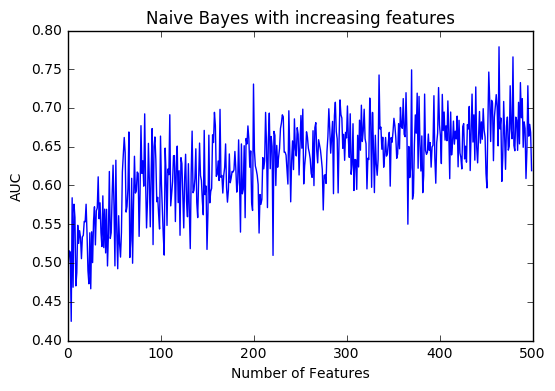

In [244]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
import numpy as np

# create some data and split into training and test sets
X, y = make_classification(n_samples=1000, n_classes=2, n_features=500, n_informative=250)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# lists to capture results for plotting below
px = []
py = []

for n in range(1,500):
   
    # pick n features at random and get corresponding inputs
    sample_features = np.random.randint(500, size=n)
    X_train_sample = X_train[:,sample_features]
    X_test_sample = X_test[:,sample_features]

    # fit bernoulli and make predictions
    modelb = BernoulliNB(binarize=0.0)
    modelb.fit(X_train_sample, y_train)
    predictions = modelb.predict_proba(X_test_sample)

    # calculate AUC, should be much better than our previous dummy classifiers!
    FPR, TPR, thresholds = metrics.roc_curve(y_test, predictions[:,1])
    px.append(n)
    py.append(metrics.auc(FPR, TPR))

# plot our data 
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(px, py)
plt.title('Naive Bayes with increasing features')
plt.xlabel('Number of Features')
plt.ylabel('AUC');

We can see that even as large amounts of features are added, in this test the performance of Naive Bayes only increases slowly.

## What next?

As we discovered, naive Bayes is naive - it won't discover any relationships between inputs to improve the model, as it assumed each input to be indepedent of each other.

Now that we understand how inputs can impact probability indepedently, we're going to explore a model that can, in a simple way, start taking advantage of relationships in those inputs.

---

[Table of Contents](00.00-Learning-ML.ipynb#Table-of-Contents) &bull; [&larr; *Chapter 2.01 - Dummy Classifiers*](02.01-Dummy-Classifiers.ipynb) &bull; [*Chapter 2.03 - k-Nearest Neighbours* &rarr;](02.03-k-Nearest-Neighbours.ipynb)